# Tanh Saturation Model

Simple model that learns tanh audio saturation without **tanh** activations in the model itself.  
The result is used only as an example, as using any tanh approximation or even full tanh in the code
would be considerably more efficient than executing inference of a model

In [ ]:
import tensorflow as tf
import numpy as np 
import random
import math
import soundfile as sf
import math

In [3]:
saturate_sample = lambda x, g : math.tanh(g*x)
saturate_list = lambda x, g : [saturate_sample(i, g) for i in x]

Generate dataset

In [4]:
slen = 100000
# generate random list signal with slen
gensignal = np.random.rand(slen)*2 - 1
gensignal = list(gensignal)
gensignal.extend((np.random.rand(slen)*2 - 1)*0.000001)
# print(gensignal[-10:])

In [5]:
X = []
y = []

for x in gensignal:
    for sat_gain in range(0,100,2):
        # small perturbation of random value between -1 and 1
        # print(sat_gain,end=" ")
        if sat_gain != 0:
            sat_gain = abs(sat_gain+np.random.uniform(-1,1))
        # print(sat_gain)
        X.append([x, sat_gain])
        y.append(saturate_sample(x,sat_gain))

In [ ]:
# Create keras model to train on tanh saturation per sample.
# It has to have 2 inputs (sample and gain) and 1 output (saturated sample)
# The gain is a scalar value
# The output is a scalar value between -1 and 1

model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, input_shape=(2,), activation='sigmoid'),
    tf.keras.layers.Dense(10, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='mean_squared_error')
model.summary()


In [7]:
# Split the data into training and validation sets
import sklearn.model_selection as sk
X_train, X_test, y_train, y_test = sk.train_test_split(X, y, test_size=0.2)

# Train the model and show with tensorboard the loss function
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


2023-07-19 12:31:28.278638: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-07-19 12:31:28.278665: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-07-19 12:31:28.278692: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 1 GPUs
2023-07-19 12:31:28.279281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-07-19 12:31:28.379735: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-07-19 12:31:28.379891: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [8]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


2023-07-19 12:31:56.586995: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-07-19 12:31:56.606858: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2599990000 Hz


Epoch 1/50
 116/3907 [..............................] - ETA: 6s - loss: 1.1571

2023-07-19 12:31:57.522803: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-07-19 12:31:57.522828: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-07-19 12:31:57.523390: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-07-19 12:31:57.526122: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-07-19 12:31:57.526937: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 0 callback api events and 0 activity events. 
2023-07-19 12:31:57.527740: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-07-19 12:31:57.529579: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20230719-123128/train/plugins/pro

3907/3907 [==============================] - 8s 2ms/step - loss: 0.3311 - val_loss: 0.0454
Epoch 2/50
3907/3907 [==============================] - 7s 2ms/step - loss: 0.0275 - val_loss: 0.0067
Epoch 3/50
3907/3907 [==============================] - 7s 2ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 4/50
3907/3907 [==============================] - 7s 2ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 5/50
3907/3907 [==============================] - 7s 2ms/step - loss: 0.0011 - val_loss: 9.2852e-04
Epoch 6/50
3907/3907 [==============================] - 7s 2ms/step - loss: 7.2262e-04 - val_loss: 5.7566e-04
Epoch 7/50
3907/3907 [==============================] - 7s 2ms/step - loss: 5.3326e-04 - val_loss: 4.0780e-04
Epoch 8/50
3907/3907 [==============================] - 7s 2ms/step - loss: 4.0748e-04 - val_loss: 3.1312e-04
Epoch 9/50
3907/3907 [==============================] - 7s 2ms/step - loss: 3.1932e-04 - val_loss: 2.4922e-04
Epoch 10/50
3907/3907 [==============================] - 

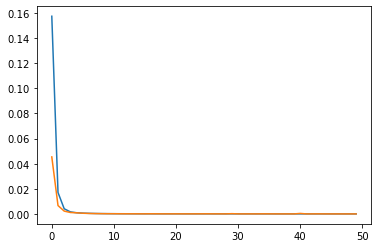

In [9]:

with tf.device('cpu'):
    history = model.fit(np.array(X_train), np.array(y_train), epochs=50, batch_size=2048, validation_data=(np.array(X_test), np.array(y_test)), callbacks=[tensorboard_callback])

# plot training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
converter.inference_input_type
plt.show()


In [46]:
# Save non quantized tflite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("saturation_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpgm48qpgk/assets


INFO:tensorflow:Assets written to: /tmp/tmpgm48qpgk/assets
2023-07-19 13:02:09.629941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 13:02:09.630179: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-07-19 13:02:09.630237: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-07-19 13:02:09.630835: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 13:02:09.631038: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.

2388

In [43]:
# Quantize the model to 8 bits
converter = tf.lite.TFLiteConverter.from_keras_model(model)
def representative_dataset_gen():
    for data in tf.data.Dataset.from_tensor_slices((X)).batch(1).take(100):
        yield [tf.dtypes.cast(data, tf.float32)]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8  # or tf.uint8
# converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = converter.convert()
# Save the model
open("saturation_model_quant.tflite", "wb").write(tflite_quant_model)


INFO:tensorflow:Assets written to: /tmp/tmpkrk_f506/assets


INFO:tensorflow:Assets written to: /tmp/tmpkrk_f506/assets
2023-07-19 12:58:56.315301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:58:56.315543: I tensorflow/core/grappler/devices.cc:69] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-07-19 12:58:56.315605: I tensorflow/core/grappler/clusters/single_machine.cc:356] Starting new session
2023-07-19 12:58:56.315839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-19 12:58:56.316037: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 Ti computeCapability: 7.5
coreClock: 1.485GHz coreCount: 16 deviceMemorySize: 3.

2992

In [44]:


# signal, sr = librosa.load('/home/cimil-01/Recordings/1-Edited/DavideRosestolato-full_length-edited_mono/acoustic_guitar_pitched_allstring4_halftonebending_f_DavRos_20200822.wav', sr=48000)

#@ Load file with soundfile instead of librosa
# import soundfile as sf

try:
    test = signal[:]
except NameError:
    print("importing signal from file")
    signal, sr = sf.read('/home/cimil-01/Recordings/1-Edited/DavideRosestolato-full_length-edited_mono/acoustic_guitar_pitched_allstring4_halftonebending_f_DavRos_20200822.wav')

# # Save audio as "clean.wav"
# sf.write('clean.wav', signal, sr)

satgain = 10
# First apply saturate_list
baseline_sat_signal = saturate_list(signal, satgain)
# Then saturate with keras model
keras_sat_signal = model.predict(np.array([[x,satgain] for x in signal]))
# predict also with tflite_quant_model

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path='saturation_model_quant.tflite')
interpreter.allocate_tensors()
# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

keras_sat_signal_quant = []
for x in baseline_sat_signal:
    x = [x, satgain]
    input_data = np.array([x], dtype=np.float32)
    # assert len(np.shape(input_data)) == len(input_shape), "input shape is not correct, %s != %s" % (np.shape(input_data), input_shape)
    assert np.all(np.shape(input_data) == input_shape), "input shape is not correct (%s != %s)" % (np.shape(input_data), input_shape)

    interpreter.set_tensor(input_details[0]['index'], input_data)

    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    keras_sat_signal_quant.append(output_data[0][0])



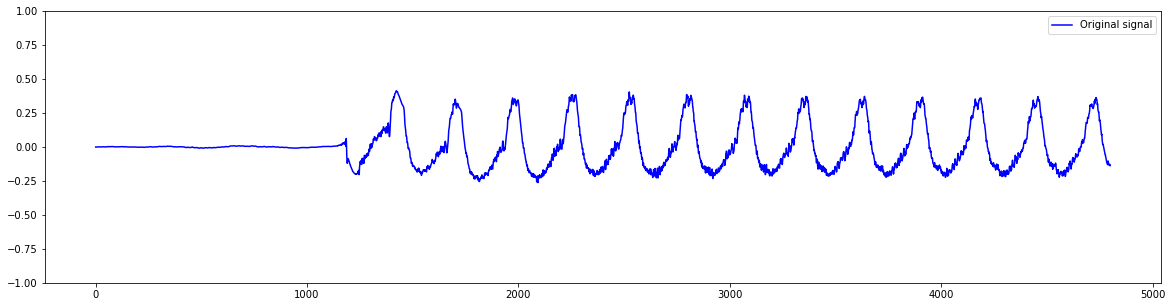

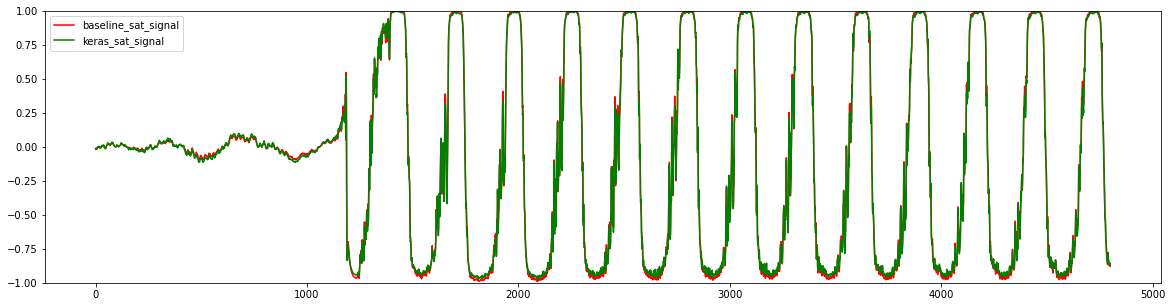

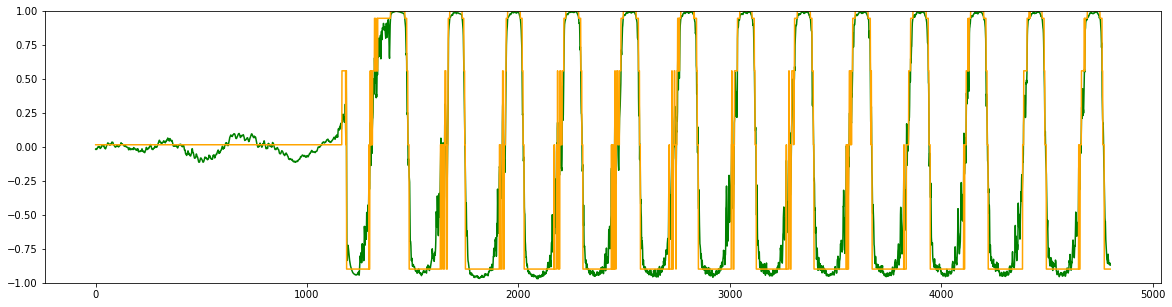

In [45]:
import matplotlib.pyplot as plt


sigstart = int(1.2*sr)
siglen = int(0.1*sr)
# determine figure size 
fig = plt.figure(figsize=(20, 5))

# plot signal with ylim -1 to 1
plt.plot(signal[sigstart:sigstart+siglen], color='blue')
plt.ylim(-1,1)
plt.legend(['Original signal'])

# plt.line(signal[sigstart:sigstart+siglen], color='blue')

fig = plt.figure(figsize=(20, 5))
plt.ylim(-1,1)

plt.plot(baseline_sat_signal[sigstart:sigstart+siglen], color='red')
plt.plot(keras_sat_signal[sigstart:sigstart+siglen], color='green')
plt.legend(['baseline_sat_signal', 'keras_sat_signal'])
plt.show()


fig = plt.figure(figsize=(20, 5))
plt.ylim(-1,1)
# keras_sat_signal_quant

plt.plot(keras_sat_signal[sigstart:sigstart+siglen], color='green')
plt.plot(keras_sat_signal_quant[sigstart:sigstart+siglen], color='orange')

